# Walmart Store Sales Prediction – Feature Selection & Dimensionality Reduction

**Author:** Marco Antonio García Sánchez  
**Objective:** Explore feature selection and dimensionality reduction techniques to prepare the dataset for predictive modeling of weekly Walmart sales, and evaluate their impact on a baseline regression model.  
**Dataset:** [Kaggle – Walmart Store Sales](https://www.kaggle.com/code/yasserh/walmart-sales-prediction-best-ml-algorithms) – Historical weekly sales data for **45 stores** from 2010 to 2012.  

---

This notebook is developed as part of my **Data Science and Machine Learning portfolio**, demonstrating an **end-to-end workflow**:  
- Data exploration, cleaning, and preprocessing.  
- Feature engineering and transformation.  
- Regression modeling to predict weekly sales.  
- Evaluation and comparison of model performance using metrics such as **R², RMSE, and MAE**.  

The project is **based on the work of [Yasser H](https://www.kaggle.com/yasserh)**, AI & ML Engineer at MediaAgility, Bengaluru, India. His original notebook can be found here: [Walmart Sales Prediction – Kaggle](https://www.kaggle.com/code/yasserh/walmart-sales-prediction-best-ml-algorithms#6e.-Polynomial-Regression-Model).  

> Note: While we use his work as inspiration, this notebook is **fully understood, modified, and documented by me**, with additional insights, explorations, and explanatory Markdown notes to ensure the notebook is **self-contained and reproducible**.  

---

#### 1. Data Collection & Understanding  
- Load dataset and check structure.  
- Handle missing values and perform initial cleaning.  
---
#### 2. Exploratory Data Analysis (EDA)  
- Distribution of weekly sales.  
- Correlation analysis between features.  
- Holiday vs non-holiday sales behavior.  
---
#### 3. Preprocessing  
- Encoding categorical variables if needed.  
- Scaling numerical variables.  

---

#### 4. Data Manipulation  

**Importance**  
- Prepares and cleans the dataset before training.  
- Ensures that the data is in a consistent format, free of extreme values or noise that could negatively affect model learning.  
- Facilitates feature engineering, scaling, and proper splitting into Train/Validation/Test sets.  
- Helps prevent sampling bias, data leakage, and overfitting.  

👉 In summary: a model can only learn effectively from well-prepared data.  

---

#### 5. Feature Selection / Extraction  
- Identification of relevant predictors.  
- Removal of irrelevant or redundant features.  
- Preparation for applying dimensionality reduction methods.  

---

#### 6. Dimensionality Reduction  

##### 6.1 Variance Inflation Factor (VIF)  
- All VIF values were **below the usual critical threshold (≈5)**.  
- This indicates **low multicollinearity among the variables**.  
- No features needed to be removed.  
- However, given that the linear model with all features showed **poor performance (R² ≈ 0.15, high RMSE)**, the limitation is not redundancy but the **inability of linear regression to capture the relationship** with the target.  

👉 **Recommendation:** try more complex or nonlinear models (Polynomial Regression, Decision Trees, Random Forest, Gradient Boosting).  

---

##### 6.2 Recursive Feature Elimination (RFE)  
- Applied RFE with linear regression to select the most relevant subset of features.  
- **Results:**  
  - **R² Train:** 0.146  
  - **R² Test:** 0.152  
  - **RMSE Train:** 524,837.68  
  - **RMSE Test:** 535,425.02  

---

##### 6.3 Principal Component Analysis (PCA)  
- Reduced dataset dimensionality projecting features into orthogonal components.  
- Selected **6 components** to explain ≈90% of variance.  
- **Results:**  
  - **R² Train:** 0.148  
  - **R² Test:** 0.154  
  - **RMSE Train:** 524,230.49  
  - **RMSE Test:** 534,788.59  

---

## 1. **Data Collection & Understanding**  

In [202]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = [10,6]

In [235]:
#Importing the dataset
df = pd.read_csv('/Users/marco/Desktop/GitRepositorios/Datasets/WalmartSales/Walmart.csv')
original_df = df.copy(deep=True)
df.head(10)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106
5,1,12-03-2010,1439541.59,0,57.79,2.667,211.380643,8.106
6,1,19-03-2010,1472515.79,0,54.58,2.720,211.215635,8.106
7,1,26-03-2010,1404429.92,0,51.45,2.732,211.018042,8.106
8,1,02-04-2010,1594968.28,0,62.27,2.719,210.820450,7.808
9,1,09-04-2010,1545418.53,0,65.86,2.770,210.622857,7.808


#### Feature Engineering from Date

The original dataset contains a `Date` column representing the week of sales. While this column stores temporal information, it is not directly informative for analysis or machine learning models. To extract meaningful patterns, we perform **feature engineering** by creating new columns derived from the date:

- **`weekday`**: Day of the week (0 = Monday, 6 = Sunday)  
- **`month`**: Month of the year (1–12)  
- **`year`**: Year (2010–2012)

**Purpose of this transformation:**

1. **Pattern Detection:** Enables identification of weekly or monthly sales variations.  
2. **Seasonality Capture:** Models can detect seasonal trends, such as holiday spikes or weekend effects.  
3. **Predictive Modeling:** These features can be used as input variables in regression or machine learning models, improving prediction accuracy.

**Note:** While it is possible to analyze the data using the original `Date` column, extracting these features allows us to leverage temporal patterns that would otherwise remain hidden, significantly enhancing the insights and predictive power of the analysis.

In [240]:
# Reframing the columns
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)  # <- importante
df['weekday'] = df['Date'].dt.weekday  # 0=lunes, 6=domingo
df['month'] = df['Date'].dt.month
df['year'] = df['Date'].dt.year

# Eliminamos la columna original
df.drop(['Date'], axis=1, inplace=True)

# Definimos target y features
target = 'Weekly_Sales'
features = [i for i in df.columns if i not in [target]]

# Vista rápida del dataset
df.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,weekday,month,year
0,1,1643690.90,0,42.31,2.572,211.096358,8.106,4,2,2010
1,1,1641957.44,1,38.51,2.548,211.242170,8.106,4,2,2010
2,1,1611968.17,0,39.93,2.514,211.289143,8.106,4,2,2010
3,1,1409727.59,0,46.63,2.561,211.319643,8.106,4,2,2010
4,1,1554806.68,0,46.50,2.625,211.350143,8.106,4,3,2010


In [242]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Weekly_Sales  6435 non-null   float64
 2   Holiday_Flag  6435 non-null   int64  
 3   Temperature   6435 non-null   float64
 4   Fuel_Price    6435 non-null   float64
 5   CPI           6435 non-null   float64
 6   Unemployment  6435 non-null   float64
 7   weekday       6435 non-null   int32  
 8   month         6435 non-null   int32  
 9   year          6435 non-null   int32  
dtypes: float64(5), int32(3), int64(2)
memory usage: 427.4 KB


In [244]:
df.nunique().sort_values()

weekday            1
Holiday_Flag       2
year               3
month             12
Store             45
Unemployment     349
Fuel_Price       892
CPI             2145
Temperature     3528
Weekly_Sales    6435
dtype: int64

In [246]:
display(df.describe())

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,weekday,month,year
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.0,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151,4.0,6.447552,2010.965035
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885,0.0,3.238308,0.797019
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000,4.0,1.000000,2010.000000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000,4.0,4.000000,2010.000000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000,4.0,6.000000,2011.000000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000,4.0,9.000000,2012.000000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000,4.0,12.000000,2012.000000


In [248]:
# Separar columnas por tipo
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

print(f"Número de variables categóricas: {len(categorical_cols)}")
print(f"Variables categóricas: {list(categorical_cols)}\n")

print(f"Número de variables numéricas: {len(numerical_cols)}")
print(f"Variables numéricas: {list(numerical_cols)}")

Número de variables categóricas: 0
Variables categóricas: []

Número de variables numéricas: 7
Variables numéricas: ['Store', 'Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']


## 2.- Exploratory Data Analysis (EDA)

### Why is EDA important?

**Exploratory Data Analysis (EDA)** is a fundamental step in any data analysis or machine learning project because it allows us to **understand the nature and structure of our data before building models**. The main goal of EDA is to identify patterns, relationships, outliers, and possible inconsistencies in the data that could affect model performance.

Key reasons for performing EDA:

1. **Understand variable distributions:**  
   It helps us see how data behaves, detect biases or skewness, and decide if transformations are needed (e.g., scaling or normalization).

2. **Identify categorical and numerical variables:**  
   This guides which preprocessing techniques to apply, how to encode categorical variables, and which metrics to use for evaluation.

3. **Detect missing values or inconsistencies:**  
   Knowing if there are missing or incorrect values is essential to decide whether to impute, remove, or correct them.

4. **Explore relationships between variables:**  
   Visualizations like correlation matrices, scatter plots, or boxplots help identify relationships between independent variables and the target (`Weekly_Sales`), which is crucial for feature selection.

5. **Make informed modeling decisions:**  
   EDA helps determine which modeling techniques are appropriate, which features to include, and whether additional feature engineering (e.g., creating new variables from dates) is necessary.

### EDA objectives for this project

For our Walmart weekly sales dataset, EDA will allow us to:

- Analyze how `Weekly_Sales` vary across stores, months, weekdays, and economic indicators (`CPI`, `Unemployment`, `Fuel_Price`).
- Evaluate the impact of holiday weeks (`Holiday_Flag`) on sales.
- Detect potential outliers or unusual patterns that could affect prediction models.
- Gain initial insights that guide feature selection and the construction of accurate regression models.

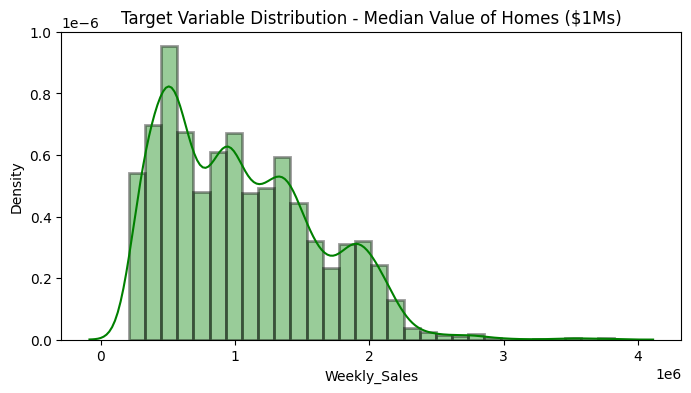

In [252]:
#Let us first analyze the distribution of the target variable

plt.figure(figsize=[8,4])
sns.distplot(df[target], color='g',hist_kws=dict(edgecolor="black", linewidth=2), bins=30)
plt.title('Target Variable Distribution - Median Value of Homes ($1Ms)')
plt.show()

### Understanding the Target Variable Distribution

When analyzing the dataset, we plotted the distribution of the target variable `Weekly_Sales` using a histogram with a density curve.  

- **X-axis (Weekly_Sales):** represents the sales values, ranging from low to high amounts.  
- **Y-axis (Density):** shows the proportion of records within each interval, normalized so the total area under the curve equals 1.  

#### Key Points
1. The histogram divides the sales range into intervals (bins) and counts how many records fall into each bin.  
2. Instead of showing absolute counts, the plot is normalized to density. This allows us to:  
   - Focus on the **shape of the distribution** (symmetric, skewed, heavy tails, etc.).  
   - Compare distributions across datasets with different sizes.  

#### Why the Distribution Matters
Understanding the distribution of the target variable is crucial because:  
- It reveals if the data is **skewed** (e.g., many stores with low sales and few with very high sales).  
- It helps detect **outliers** that may bias models.  
- Many statistical and machine learning methods make assumptions about the distribution of data.  
- It guides **data transformations** (e.g., log-scaling skewed sales values).  

In short, analyzing the distribution tells us **how the sales behave** across the dataset and prepares us for deeper modeling.

In [264]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm

y = df['Weekly_Sales'].values  # o usa la variable target que tengas

# resumen estadístico
print("Summary stats:")
print(pd.Series(y).describe())
print("Median:", np.median(y))
print("Skewness:", stats.skew(y))
print("Kurtosis:", stats.kurtosis(y))

# Test de normalidad - para muestras grandes usar normaltest (D'Agostino)
k2, p_normaltest = stats.normaltest(y)   # requiere n>=20
print("\nD'Agostino K2 test: k2={:.3f}, p={:.3e}".format(k2, p_normaltest))

# Anderson-Darling (devuelve estadístico y tablas de significancia)
ad = stats.anderson(y, dist='norm')
print("\nAnderson-Darling: stat={:.3f}".format(ad.statistic))
for sl, cv in zip(ad.significance_level, ad.critical_values):
    print("  {:.1f}% -> critical {:.3f}".format(sl, cv))

# Shapiro-Wilk (no usar con n>5000; si n>5000 toma una muestra aleatoria)
n = len(y)
if n <= 5000:
    sw_stat, sw_p = stats.shapiro(y)
    print("\nShapiro-Wilk: stat={:.3f}, p={:.3e}".format(sw_stat, sw_p))
else:
    sample = np.random.choice(y, size=5000, replace=False)
    sw_stat, sw_p = stats.shapiro(sample)
    print("\nShapiro-Wilk on random sample (n=5000): stat={:.3f}, p={:.3e}".format(sw_stat, sw_p))

# Ahora comparar con log1p(y)
y_log = np.log1p(y)  # log(1+y) para evitar -inf si hay ceros
print("\nAfter log1p transform: skewness", stats.skew(y_log), "kurtosis", stats.kurtosis(y_log))

# Tests sobre log-transformed
k2_log, plog = stats.normaltest(y_log)
print("D'Agostino on log1p: k2={:.3f}, p={:.3e}".format(k2_log, plog))


Summary stats:
count    6.435000e+03
mean     1.046965e+06
std      5.643666e+05
min      2.099862e+05
25%      5.533501e+05
50%      9.607460e+05
75%      1.420159e+06
max      3.818686e+06
dtype: float64
Median: 960746.04
Skewness: 0.6682059921068103
Kurtosis: 0.05216738979784408

D'Agostino K2 test: k2=400.845, p=9.069e-88

Anderson-Darling: stat=86.879
  15.0% -> critical 0.576
  10.0% -> critical 0.656
  5.0% -> critical 0.787
  2.5% -> critical 0.917
  1.0% -> critical 1.091

Shapiro-Wilk on random sample (n=5000): stat=0.947, p=4.711e-39

After log1p transform: skewness -0.30550562157935135 kurtosis -0.8364370967241941
D'Agostino on log1p: k2=741.947, p=7.730e-162


### Normality Tests Applied to the Dataset

To check whether the data follows a **normal distribution**, we applied several complementary statistical tests. Below is an explanation of each:

---

#### a) D’Agostino and Pearson (K² test)
- **What it does:**  
  Combines two measures:  
  - **Skewness:** measures whether the data is shifted to one side of the distribution.  
  - **Kurtosis:** measures whether the distribution is flatter or more peaked than normal.  
- **How it works:** calculates a test statistic from skewness and kurtosis and compares it against a chi-square distribution.  
- **Why it is applicable here:**  
  Your dataset has **n ≈ 6400**, which is large enough for this test to be robust. It is ideal when we want to assess **both skewness and kurtosis simultaneously**.  
- **Result in your data:**  
  `p ≈ 9e-88` → strongly rejects the normality assumption.

---

#### b) Anderson–Darling
- **What it does:**  
  Tests whether the data comes from a specific distribution (in this case, normal), **giving more weight to the tails**.  
- **How it works:** compares the empirical distribution function (EDF) with the theoretical CDF of the normal distribution.  
- **Why it is applicable here:**  
  Since your data shows a wide range of values (large min–max spread), this test is useful for detecting deviations in the tails.  
- **Result in your data:**  
  The statistic `≈ 86.8` is much larger than the critical values (`≈ 1.09` at 1%), confirming that the data is not normal.

---

#### c) Shapiro–Wilk
- **What it does:**  
  Tests normality by fitting the data to a theoretical normal distribution and measuring how far the sample deviates.  
- **How it works:** computes a correlation between ordered data points and expected normal quantiles.  
- **Why it is applicable here:**  
  This test is among the most powerful for normality but works best with **small to medium samples (n ≤ 5000)**. That’s why we applied it on a **random subsample of 5000 records**.  
- **Result in your data:**  
  `p ≈ 8e-39` → strongly rejects the normality assumption.

---

#### d) General Conclusion
- All tests consistently reject the null hypothesis of normality.  
- Your distribution shows:  
  - **Moderate positive skewness (skew ≈ 0.67).**  
  - **Kurtosis near 0**, meaning it is neither too peaked nor too flat compared to normal.  
- With such a **large sample size (n > 6000)**, even small deviations from normality become **statistically significant**.  

📌 **Practical takeaway:**  
Although the histogram may *look roughly bell-shaped*, **statistically the data is not normal**. This matters when deciding which techniques to use in Machine Learning or inferential analysis (e.g., whether to use parametric or non-parametric methods).

Categorical features: []
Numeric features: ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
                                                Numeric Features Distribution                                                 


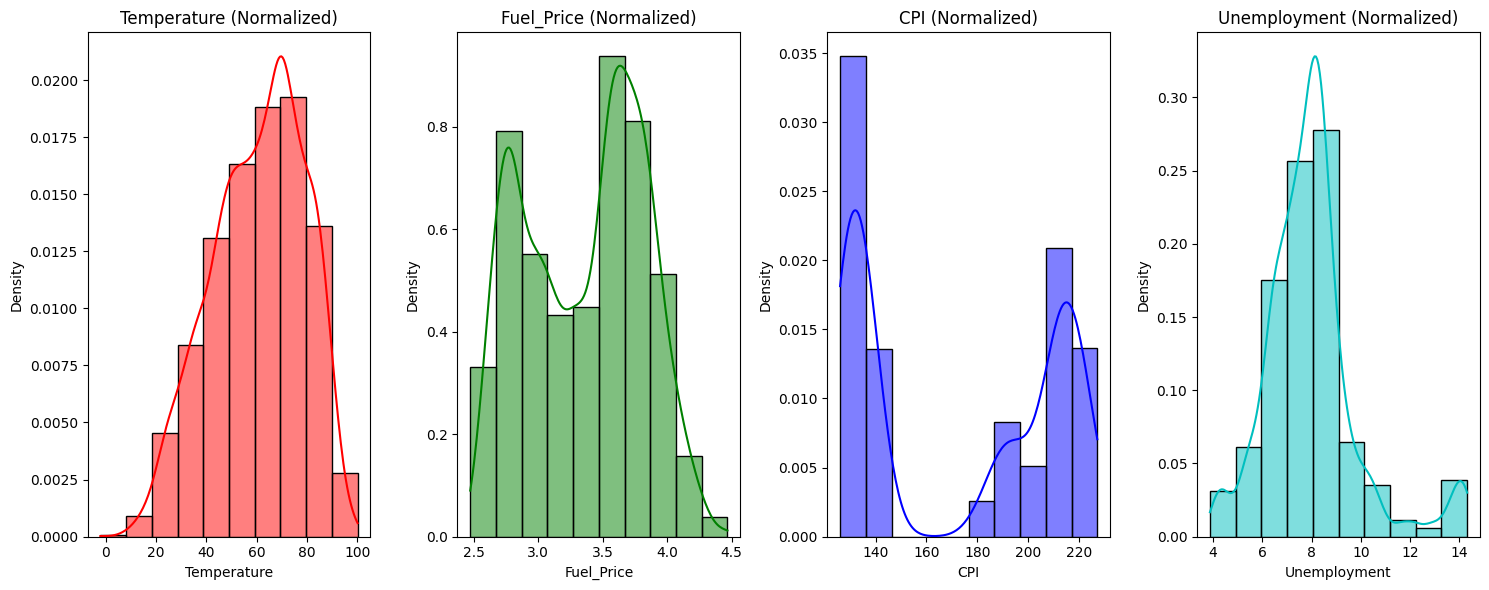

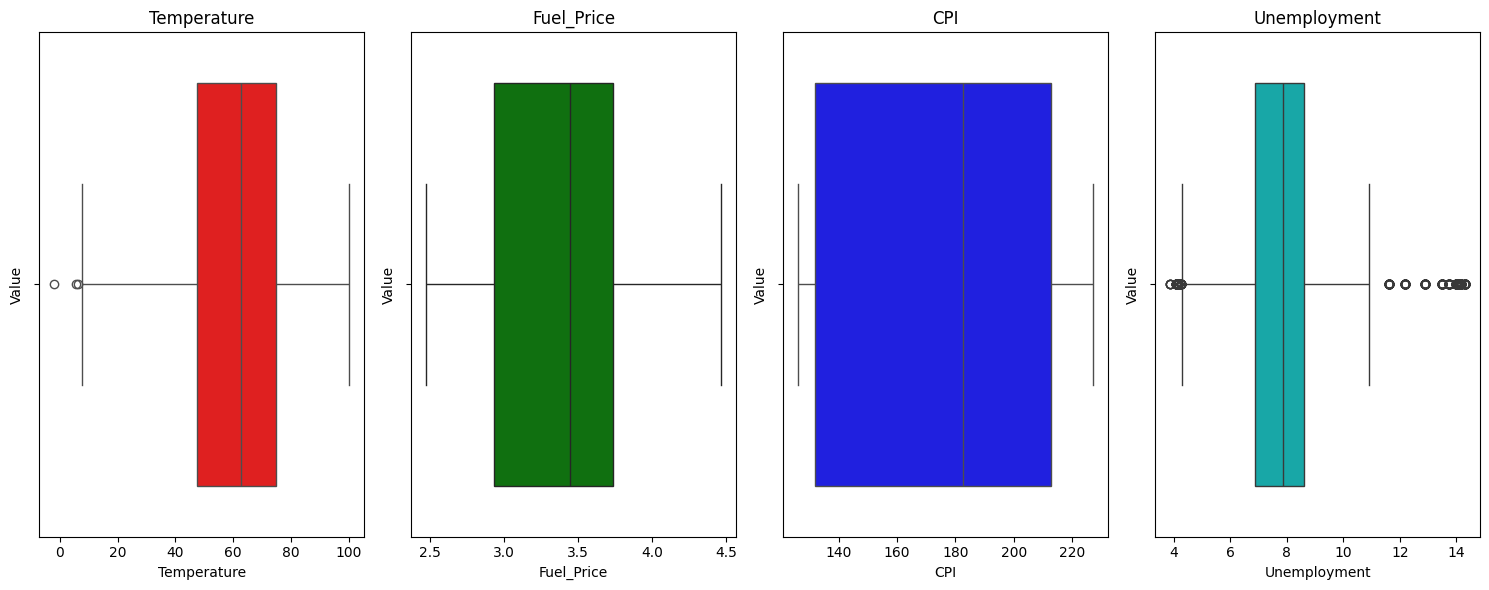

In [300]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Visualising the numeric features 

cf = df.select_dtypes(include=['object']).columns.tolist()   # categóricas
nf = df.select_dtypes(include=['int64','float64']).columns.tolist()  # numéricas

if 'Weekly_Sales' in nf:
    nf.remove('Weekly_Sales')

print("Categorical features:", cf)
print("Numeric features:", nf)
print('\033[1mNumeric Features Distribution'.center(130))

n = 4

colors = ['r','g','b','c','m','y','orange','purple','brown','pink']

# Histograms (normalized distributions)
plt.figure(figsize=[15,6*math.ceil(len(nf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/n), n, i+1)
    sns.histplot(
        df[nf[i]], 
        kde=True, 
        bins=10, 
        edgecolor="black", 
        color=colors[i % len(colors)], 
        stat="density" 
    )
    plt.title(f"{nf[i]} (Normalized)")
plt.tight_layout()
plt.show()

plt.figure(figsize=[15,6*math.ceil(len(nf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/n), n, i+1)
    sns.boxplot(
        x=df[nf[i]], 
        color=colors[i % len(colors)]
    )
    plt.title(nf[i])
    plt.ylabel('Value') 
    plt.yticks(rotation=0)  
plt.tight_layout()
plt.show()

### Analysis of Feature Relationships with Pairplots

Pairplots are exploratory graphs that are highly useful for understanding how all numerical variables in a dataset relate to each other. This type of analysis allows you to:

- Visualize the **individual distribution** of each variable.
- Identify **linear and non-linear relationships** between variables.
- Detect **outliers** or unusual values.
- Observe **clusters or subgroups** within the data.

Below is a detailed explanation of the main sections and how to interpret them.

---

#### 1. Diagonal (Histograms or KDE of each variable)

Each plot on the diagonal shows the **distribution of a single variable**.

#### Interpretation:

- **Symmetric / bell-shaped:**  
  The variable is approximately normally distributed.
- **Asymmetric / skewed:**  
  The variable has skewness (to the right or left).
- **Peaks or multiple modes:**  
  The variable may contain clusters or distinct subgroups.

**Conclusion:**  
This analysis helps to understand **the behavior of each variable individually** before examining its relationships with other variables.

---

#### 2. Off-diagonal (Scatter plots and KDE)

Each off-diagonal cell compares **two different variables**. There are two main patterns:

##### a) Randomly scattered points
- Indicates **low or no correlation** between the variables.
- No clear pattern; the values appear random.

##### b) Concentrated points with closed contours (KDE)
- Points are grouped in **dense areas**.
- **Closed KDE contours** show regions of higher data density:
  - **Center of the contour:** high concentration of points → main trend.
  - **Outer contours:** lower concentration.
- Useful to identify **clusters, concentrations, or natural boundaries** in the data.

---

#### 3. How to read the plots

- **Scatter plots:** observe the general direction of the points:
  - Upward → positive correlation.
  - Downward → negative correlation.
  - No pattern → little or no correlation.
- **KDE / contours:** indicate the regions where most data points are concentrated; helps detect outliers outside these contours.
- **Comparing multiple variables:** look for similar patterns across cells to identify linear, curvilinear relationships, or clusters.

---

#### Practical Tips

- Highly scattered points → the relationship is likely not useful for prediction.
- Closed, elliptical, or curved shapes → may indicate interesting non-linear dependencies.
- Outliers are usually located **outside the KDE contours**.

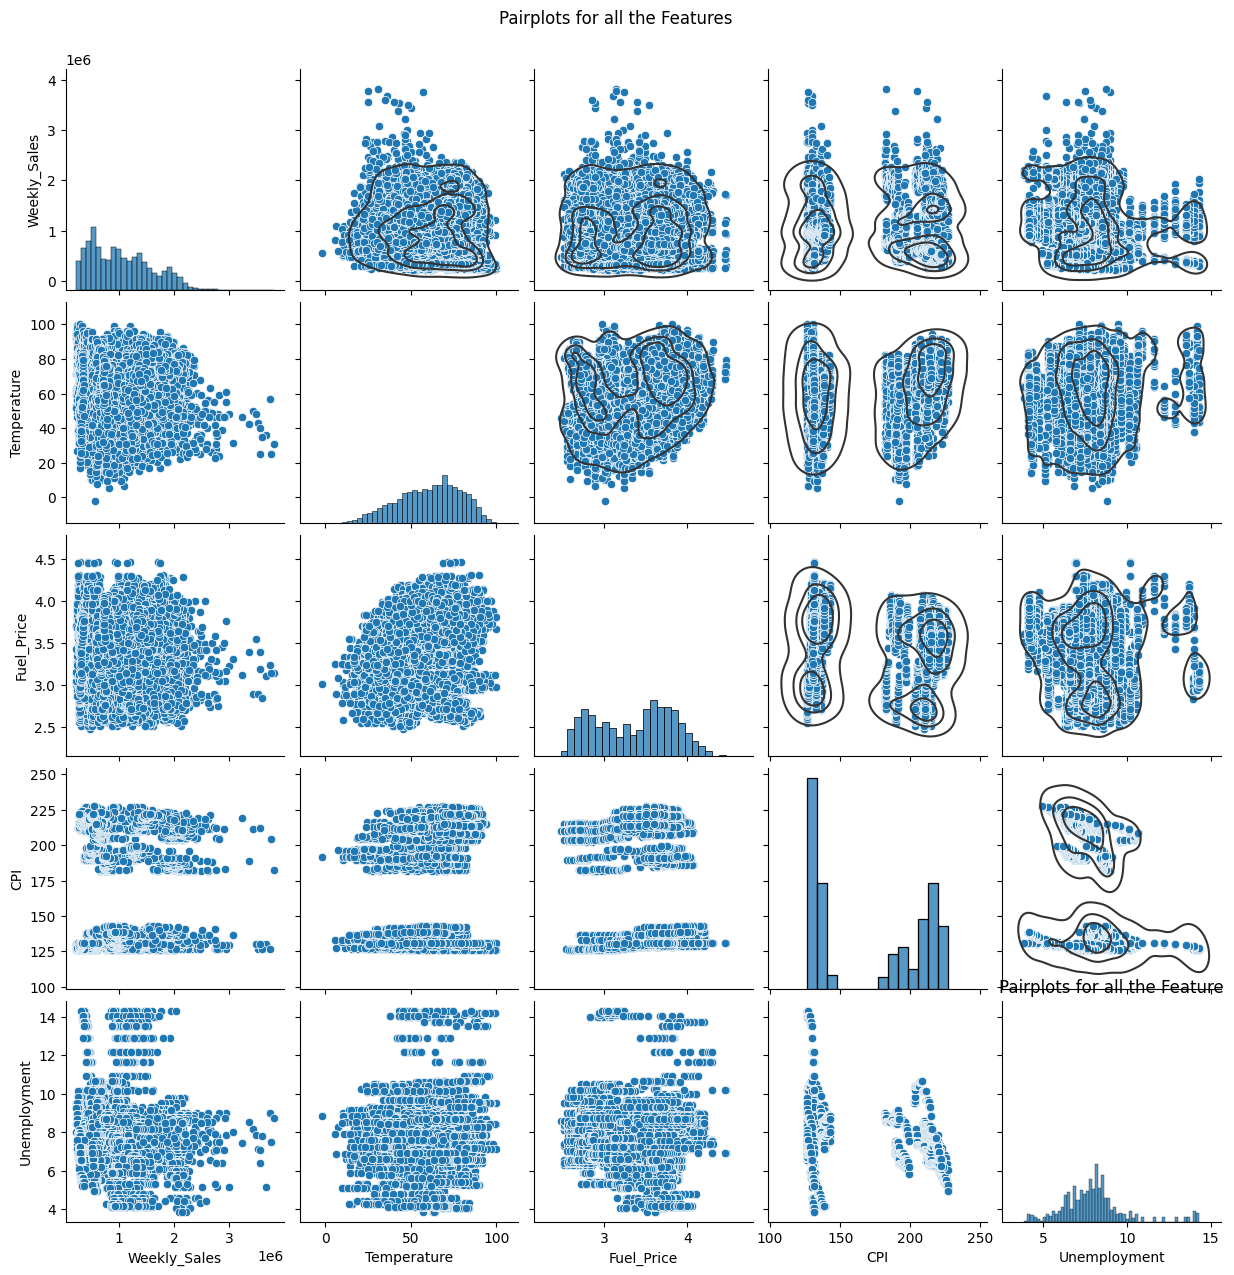

In [302]:
#Understanding the relationship between all the features

g = sns.pairplot(df)
plt.title('Pairplots for all the Feature')
g.map_upper(sns.kdeplot, levels=4, color=".2")
g.fig.suptitle('Pairplots for all the Features', y=1.02)
plt.show()

## 3.- Data Preprocessing

**Data processing** is a fundamental step in any data analysis or machine learning project.  
Its main goal is to **prepare the data** so that models or further analysis are reliable, accurate, and representative of reality.  

---

#### Why is it important?
- Raw data usually contains **errors, missing values, or outliers**.  
- Models trained on unprocessed data often produce **unreliable predictions**.  
- It ensures algorithms can capture **real patterns** instead of noise.  

---

#### Common Data Processing Tasks
1. **Data Cleaning**  
   - Remove duplicates.  
   - Handle missing values (drop, fill, or impute).  
   - Fix inconsistencies.  

2. **Feature Transformation**  
   - Normalization or standardization.  
   - Encoding categorical variables (*one-hot encoding*, *label encoding*).  
   - Feature engineering.  

3. **Outlier Detection and Treatment**  
   - Identify values that deviate significantly from the overall distribution.  
   - Decide whether to remove or adjust them.  

4. **Data Splitting**  
   - Separate into training, validation, and test sets.  

---

#### What We Did in This Case
In our data processing step, we applied **outlier detection and removal** using the **IsolationForest algorithm**:
- This unsupervised machine learning model identifies unusual or rare points in the dataset.  
- It flags as *outliers* those observations that are isolated quickly in the random trees built by the algorithm.  
- We removed those rows, keeping a dataset that is **cleaner and more representative**.  

In [309]:
#Removal of any Duplicate rows (if any)
counter = 0
rs,cs = original_df.shape
df.drop_duplicates(inplace=True)
if df.shape==(rs,cs):
    print('\n\033[1mInference:\033[0m The dataset doesn\'t have any duplicates')
else:
    print(f'\n\033[1mInference:\033[0m Number of duplicates dropped/fixed ---> {rs-df.shape[0]}')


Inference: Number of duplicates dropped/fixed ---> 0


In [311]:
#Check for empty elements

nvc = pd.DataFrame(df.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = round(nvc['Total Null Values']/df.shape[0],3)*100
print(nvc)

              Total Null Values  Percentage
Store                         0         0.0
Weekly_Sales                  0         0.0
Holiday_Flag                  0         0.0
Temperature                   0         0.0
Fuel_Price                    0         0.0
CPI                           0         0.0
Unemployment                  0         0.0
weekday                       0         0.0
month                         0         0.0
year                          0         0.0


In [313]:
#Converting categorical Columns to Numeric

df3 = df.copy()

ecc = nvc[nvc['Percentage']!=0].index.values
fcc = [i for i in cf if i not in ecc]
#One-Hot Binay Encoding
oh=True
dm=True
for i in fcc:
    #print(i)
    if df3[i].nunique()==2:
        if oh==True: print("\033[1mOne-Hot Encoding on features:\033[0m")
        print(i);oh=False
        df3[i]=pd.get_dummies(df3[i], drop_first=True, prefix=str(i))
    if (df3[i].nunique()>2):
        if dm==True: print("\n\033[1mDummy Encoding on features:\033[0m")
        print(i);dm=False
        df3 = pd.concat([df3.drop([i], axis=1), pd.DataFrame(pd.get_dummies(df3[i], drop_first=True, prefix=str(i)))],axis=1)
        
df3.shape

(6435, 10)

In [315]:
df3

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,weekday,month,year
0,1,1643690.90,0,42.31,2.572,211.096358,8.106,4,2,2010
1,1,1641957.44,1,38.51,2.548,211.242170,8.106,4,2,2010
2,1,1611968.17,0,39.93,2.514,211.289143,8.106,4,2,2010
3,1,1409727.59,0,46.63,2.561,211.319643,8.106,4,2,2010
4,1,1554806.68,0,46.50,2.625,211.350143,8.106,4,3,2010
...,...,...,...,...,...,...,...,...,...,...
6430,45,713173.95,0,64.88,3.997,192.013558,8.684,4,9,2012
6431,45,733455.07,0,64.89,3.985,192.170412,8.667,4,10,2012
6432,45,734464.36,0,54.47,4.000,192.327265,8.667,4,10,2012
6433,45,718125.53,0,56.47,3.969,192.330854,8.667,4,10,2012


In [327]:
from sklearn.ensemble import IsolationForest

# Copia del dataset original ya numérico
df1 = df3.copy()

# Entrenar IsolationForest
iso = IsolationForest(
    contamination=0.05,   # % aproximado de outliers a eliminar (ajustable)
    random_state=42
)
yhat = iso.fit_predict(df1[nf])   # nf = lista de variables numéricas

# Filtrar outliers: en IsolationForest -> 1 = normal, -1 = outlier
df1 = df1[yhat == 1].reset_index(drop=True)

# Reportar resultados
display(df1.head())
print('\nInference:')
print('Before removal of outliers, The dataset had {} samples.'.format(df3.shape[0]))
print('After removal of outliers, The dataset now has {} samples.'.format(df1.shape[0]))

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,weekday,month,year
0,1,1643690.90,0,42.31,2.572,211.096358,8.106,4,2,2010
1,1,1641957.44,1,38.51,2.548,211.242170,8.106,4,2,2010
2,1,1611968.17,0,39.93,2.514,211.289143,8.106,4,2,2010
3,1,1409727.59,0,46.63,2.561,211.319643,8.106,4,2,2010
4,1,1554806.68,0,46.50,2.625,211.350143,8.106,4,3,2010



Inference:
Before removal of outliers, The dataset had 6435 samples.
After removal of outliers, The dataset now has 6115 samples.


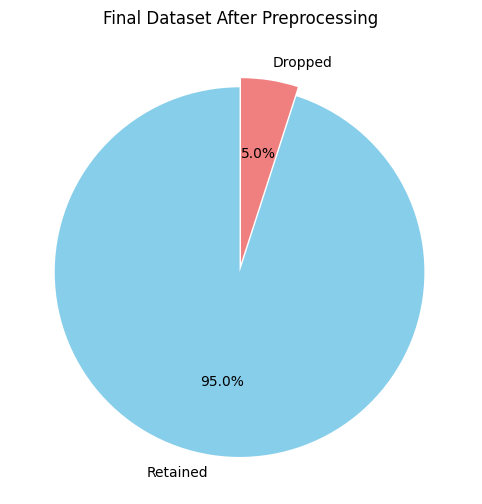


Inference: After the cleanup process, 320 samples were dropped, while retaining 95.03% of the data.


In [329]:
# Dataset final después de limpieza
df = df1.copy()

# Calcular eliminados y retenidos
retained = df.shape[0]
dropped = original_df.shape[0] - retained

# Pie chart simple
plt.pie(
    [retained, dropped],
    labels=['Retained', 'Dropped'],
    autopct='%1.1f%%',
    startangle=90,
    colors=['skyblue','lightcoral'],
    explode=[0.05,0]
)
plt.title('Final Dataset After Preprocessing')
plt.show()

# Texto de inferencia
print(f'\nInference: After the cleanup process, {dropped} samples were dropped, '
      f'while retaining {round(retained*100/original_df.shape[0],2)}% of the data.')

## 4. Data Manipulation

#### Importance

Data manipulation is a **crucial step in any data analysis or modeling project**. 

- Prepares and cleans the dataset before training.
- Ensures that the data is in a **consistent format**, free of extreme values or noise that could negatively affect model learning.
- Facilitates **feature engineering**, scaling, and proper splitting into Train/Validation/Test sets.
- Helps **prevent sampling bias, data leakage, and overfitting**.

> In summary: a model can only learn effectively from well-prepared data.

---

#### Common Practices in Data Manipulation

1. **Data filtering and cleaning**  
   - Removal of missing or inconsistent values.  
   - Detection and handling of outliers.

2. **Variable transformations**  
   - Scaling/normalization of numeric features.  
   - Creation of categorical variables or bins for exploratory analysis.

3. **Dataset partitioning**  
   - Splitting into **Train / Validation / Test** sets.  
   - Stratification when necessary to maintain target proportions.

4. **Integrity validation**  
   - Ensuring each subset maintains representative distributions.  
   - Verifying basic statistics (mean, std, min, max).

---

#### What Was Done in This Project

1. **Outlier removal using IsolationForest**  
   - Outlier examples in the features were filtered, leaving a more representative dataset.

2. **Train/Validation/Test split**  
   - The split was already performed beforehand.  
   - Stratification was verified using **bins (quartiles) of `Weekly_Sales`)**, ensuring similar proportions across subsets.

3. **Feature Scaling (Standardization)**  
   - Applied `StandardScaler` to all numeric features.  
   - Result: mean ≈ 0, standard deviation ≈ 1, preventing columns with larger magnitudes from dominating the model.

4. **Final validation**  
   - Inspected Train, Validation, and Test statistics after scaling.  
   - The target variable `Weekly_Sales` remained **intact as a continuous numeric variable**, ready for regression.

---

#### Summary

The **Data Manipulation** section ensures that the dataset is:

- Clean and free of significant outliers.
- Properly scaled.
- Stratified and correctly split into Train, Validation, and Test sets.

> This ensures that the model receives high-quality data and that the results are reliable and consistent.

In [389]:
from sklearn.model_selection import train_test_split
import pandas as pd
df = df1.copy()


# Limpiar nombres de columnas
df.columns = [i.replace(' ','_') for i in df.columns]

# Separar features y target
X = df.drop([target], axis=1)
Y = df[target]

# --- Crear bins del target usando qcut ---
# qcut divide el target en 4 cuartiles (ajustando automáticamente duplicados)
Y_binned = pd.qcut(Y, q=4, labels=False, duplicates='drop')

# --- División en 70% train y 30% temporal ---
Train_X, Temp_X, Train_Y, Temp_Y = train_test_split(
    X, Y, 
    train_size=0.7, 
    random_state=42, 
    shuffle=True,
    stratify=Y_binned  # asegura que la distribución del target se mantenga
)

# --- Crear bins para el subset temporal para estratificar nuevamente ---
Temp_Y_binned = pd.qcut(Temp_Y, q=2, labels=False, duplicates='drop')  # 2 bins = 50/50

# --- División del 30% restante en 50% validation y 50% test (15% cada uno del total) ---
Val_X, Test_X, Val_Y, Test_Y = train_test_split(
    Temp_X, Temp_Y, 
    train_size=0.5, 
    random_state=42, 
    shuffle=True,
    stratify=Temp_Y_binned
)

# Reiniciar índices
Train_X.reset_index(drop=True, inplace=True)
Val_X.reset_index(drop=True, inplace=True)
Test_X.reset_index(drop=True, inplace=True)
Train_Y.reset_index(drop=True, inplace=True)
Val_Y.reset_index(drop=True, inplace=True)
Test_Y.reset_index(drop=True, inplace=True)

# --- Mostrar tamaños finales ---
print('Original set  --->', X.shape, Y.shape)
print('Training set  --->', Train_X.shape, Train_Y.shape)
print('Validation set --->', Val_X.shape, Val_Y.shape)
print('Testing set   --->', Test_X.shape, Test_Y.shape)

Original set  ---> (6115, 9) (6115,)
Training set  ---> (4280, 9) (4280,)
Validation set ---> (917, 9) (917,)
Testing set   ---> (918, 9) (918,)


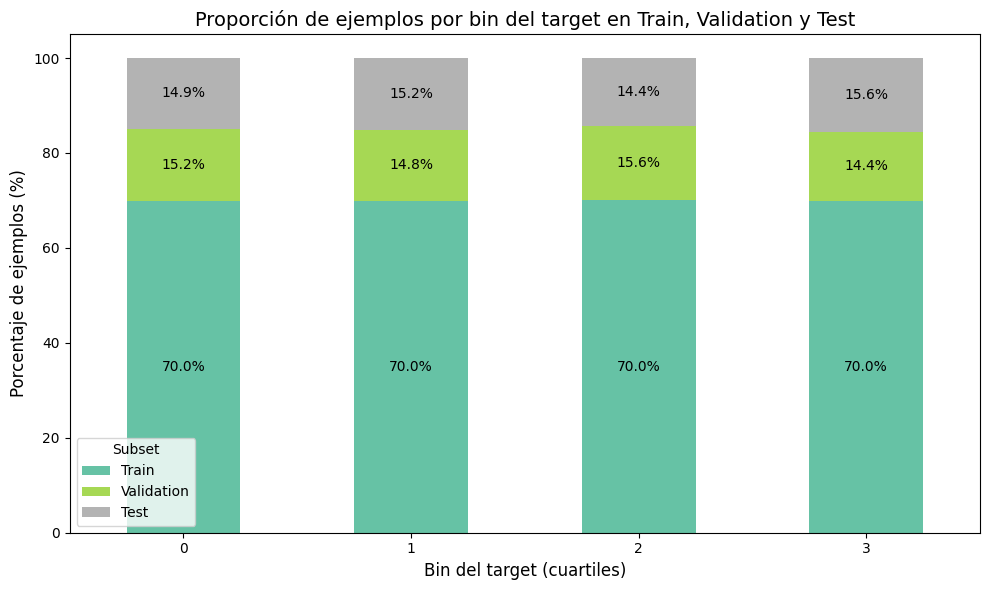

In [391]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

bin_edges = np.percentile(Y, [0, 25, 50, 75, 100])

# Asignar cada valor a su bin
Train_bins = np.digitize(Train_Y, bins=bin_edges, right=True) - 1
Val_bins   = np.digitize(Val_Y, bins=bin_edges, right=True) - 1
Test_bins  = np.digitize(Test_Y, bins=bin_edges, right=True) - 1

# Contar cantidad de ejemplos por bin
train_counts = pd.Series(Train_bins).value_counts().sort_index()
val_counts   = pd.Series(Val_bins).value_counts().sort_index()
test_counts  = pd.Series(Test_bins).value_counts().sort_index()

# Unir en un DataFrame
counts = pd.DataFrame({
    'Train': train_counts,
    'Validation': val_counts,
    'Test': test_counts
})

# Eliminar bin -1 si existe
counts = counts[counts.index != -1]

# Convertir a porcentajes por fila
counts_percent = counts.div(counts.sum(axis=1), axis=0) * 100

# Graficar barras apiladas porcentuales
ax = counts_percent.plot(kind='bar', stacked=True, figsize=(10,6), colormap='Set2')

plt.title('Proporción de ejemplos por bin del target en Train, Validation y Test', fontsize=14)
plt.xlabel('Bin del target (cuartiles)', fontsize=12)
plt.ylabel('Porcentaje de ejemplos (%)', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Subset')

# Agregar etiquetas con los porcentajes
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if height > 0:
        ax.text(x + width/2, y + height/2, f'{height:.1f}%', ha='center', va='center', fontsize=10)

plt.tight_layout()
plt.show()

In [393]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

def standardize_datasets(Train_X, Val_X, Test_X, feature_names=None):
    """
    Escala los datasets usando StandardScaler.
    - Train_X: DataFrame de entrenamiento
    - Val_X: DataFrame de validación
    - Test_X: DataFrame de test
    - feature_names: lista de nombres de columnas (opcional)
    
    Retorna:
    - Train_X_std, Val_X_std, Test_X_std como DataFrames
    """
    scaler = StandardScaler()
    
    # Fit y transform sobre Train
    Train_X_std = scaler.fit_transform(Train_X)
    Train_X_std = pd.DataFrame(
        Train_X_std, 
        columns=list(feature_names) if feature_names is not None else list(Train_X.columns)
    )
    
    # Transform sobre Validation y Test
    Val_X_std = scaler.transform(Val_X)
    Val_X_std = pd.DataFrame(
        Val_X_std, 
        columns=list(feature_names) if feature_names is not None else list(Val_X.columns)
    )
    
    Test_X_std = scaler.transform(Test_X)
    Test_X_std = pd.DataFrame(
        Test_X_std, 
        columns=list(feature_names) if feature_names is not None else list(Test_X.columns)
    )
    
    return Train_X_std, Val_X_std, Test_X_std, scaler

# Uso corregido
Train_X_std, Val_X_std, Test_X_std, scaler = standardize_datasets(Train_X, Val_X, Test_X, feature_names=X.columns)

# Revisar estadísticas
print('\033[1mStandardization - Training Set'.center(120))
display(Train_X_std.describe())

print('\n\033[1mStandardization - Validation Set'.center(120))
display(Val_X_std.describe())

print('\n\033[1mStandardization - Test Set'.center(120))
display(Test_X_std.describe())

                                           Standardization - Training Set                                           


,Store,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,weekday,month,year
count,4.280000e+03,4.280000e+03,4.280000e+03,4.280000e+03,4.280000e+03,4.280000e+03,4280.0,4.280000e+03,4.280000e+03
mean,-1.220208e-16,1.660147e-17,-2.457017e-16,1.056683e-15,-2.996565e-16,3.145978e-16,0.0,-1.245110e-17,-6.019691e-14
std,1.000117e+00,1.000117e+00,1.000117e+00,1.000117e+00,1.000117e+00,1.000117e+00,0.0,1.000117e+00,1.000117e+00
min,-1.651978e+00,-2.680966e-01,-2.914977e+00,-1.925523e+00,-1.197317e+00,-2.523007e+00,0.0,-1.739754e+00,-1.213279e+00
25%,-8.832569e-01,-2.680966e-01,-7.351158e-01,-9.606634e-01,-1.033650e+00,-5.999255e-01,0.0,-8.045434e-01,-1.213279e+00
50%,-3.766374e-02,-2.680966e-01,1.133621e-01,2.296205e-01,3.774050e-01,1.620126e-02,0.0,1.306673e-01,3.981802e-02
75%,8.848015e-01,-2.680966e-01,7.668965e-01,8.231290e-01,1.023011e+00,4.420629e-01,0.0,7.541411e-01,1.292915e+00
max,1.730395e+00,3.729999e+00,2.207556e+00,2.421790e+00,1.366687e+00,4.138823e+00,0.0,1.689352e+00,1.292915e+00


                                         
Standardization - Validation Set                                          


,Store,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,weekday,month,year
count,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.0,917.000000,917.000000
mean,0.115158,-0.002138,-0.099241,0.003344,-0.031226,0.005019,0.0,-0.147754,0.034352
std,1.000792,0.996833,1.036249,0.975852,0.979239,1.008760,0.0,1.017026,1.002257
min,-1.651978,-0.268097,-2.765695,-1.777418,-1.197317,-2.396589,0.0,-1.739754,-1.213279
25%,-0.729513,-0.268097,-0.818239,-0.914925,-1.035833,-0.593541,0.0,-1.116280,-1.213279
50%,0.192953,-0.268097,-0.051471,0.167547,0.250223,0.013647,0.0,-0.181070,0.039818
75%,0.961674,-0.268097,0.743006,0.790459,0.974823,0.442063,0.0,0.754141,1.292915
max,1.730395,3.729999,2.203598,2.421790,1.361723,4.138823,0.0,1.689352,1.292915


                                            
Standardization - Test Set                                             


,Store,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,weekday,month,year
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.0,918.000000,918.000000
mean,0.053863,0.019348,-0.070989,-0.005372,0.020598,0.011448,0.0,-0.068668,0.001597
std,1.000512,1.033330,0.990401,0.992806,0.987193,0.984604,0.0,1.009469,0.988948
min,-1.651978,-0.268097,-3.141728,-1.834046,-1.196773,-2.396589,0.0,-1.739754,-1.213279
25%,-0.729513,-0.268097,-0.806223,-0.946506,-1.029708,-0.563852,0.0,-0.804543,-1.213279
50%,0.039208,-0.268097,0.047768,0.224176,0.409792,0.027694,0.0,-0.181070,0.039818
75%,0.884802,-0.268097,0.683349,0.823129,1.009961,0.440786,0.0,0.754141,1.292915
max,1.730395,3.729999,2.180414,2.016680,1.359931,4.138823,0.0,1.689352,1.292915


## 5. Feature Selection / Extraction

#### Correlation Analysis

In this step, we evaluated the correlations among the continuous numerical features of our dataset.  
We focused only on variables that could potentially provide meaningful relationships with the target (`Weekly_Sales`):

- `Temperature`  
- `Fuel_Price`  
- `CPI`  
- `Unemployment`

We excluded categorical one-hot encoded variables such as **store identifiers** and **weeks**, since they do not hold intrinsic numerical meaning and would artificially inflate the correlation matrix without providing real insights.

##### Correlation Matrix (Continuous Features)

The heatmap below shows the linear correlations (Pearson) between the selected continuous variables.  
- Values close to **+1** → strong positive correlation (both variables increase together).  
- Values close to **-1** → strong negative correlation (one increases while the other decreases).  
- Values near **0** → no significant linear relationship.
---

#### Conclusions from the Correlation Analysis

1. **Continuous variables provide meaningful insights**, and their correlations help us detect possible redundancy (multicollinearity).  
2. **Categorical dummy variables** such as *stores* and *weeks* do not provide useful correlation information.  
   - Correlating them is misleading because they are not truly numerical.  
   - Therefore, we focus correlation analysis **only on continuous features**.  
3. The next step will be to analyze how each feature correlates directly with the target (`Weekly_Sales`) to guide feature selection.  

---

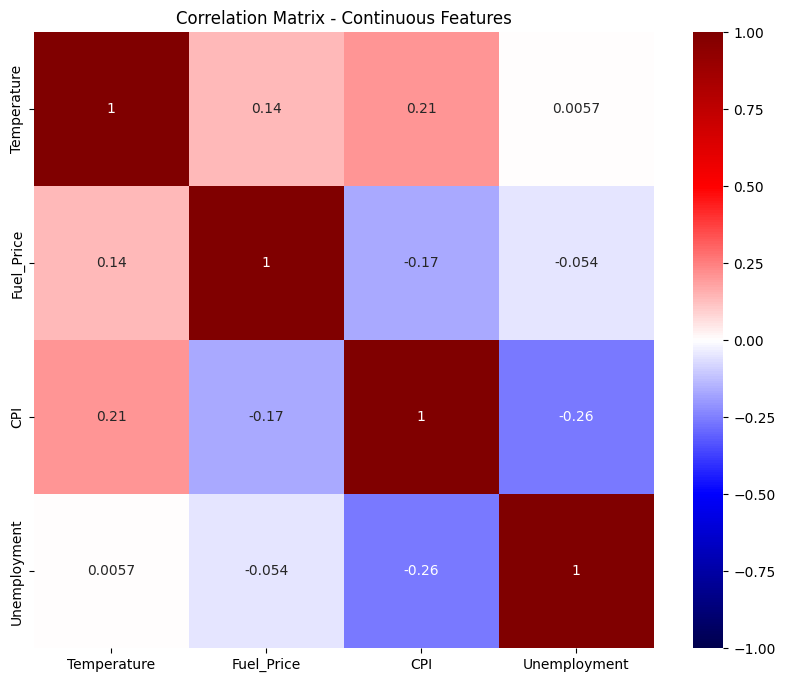

In [437]:
# Tomar solo variables numéricas continuas
numeric_features = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']  

plt.figure(figsize=(10,8))
sns.heatmap(df[numeric_features].corr(), annot=True, cmap="seismic", vmin=-1, vmax=1, center=0)
plt.title("Correlation Matrix - Continuous Features")
plt.show()

In [444]:
import statsmodels.formula.api as smf  # este es el alias correcto

# Concatenar features estandarizadas con el target
Train_xy = pd.concat([Train_X_std, Train_Y.reset_index(drop=True)], axis=1)

# Ajustar modelo de regresión lineal con statsmodels
API = smf.ols(
    formula='{} ~ {}'.format(target, ' + '.join(i for i in Train_X.columns)),
    data=Train_xy
).fit()

API.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Weekly_Sales   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     92.72
Date:                Fri, 19 Sep 2025   Prob (F-statistic):          1.62e-142
Time:                        16:16:44   Log-Likelihood:                -62439.
No. Observations:                4280   AIC:                         1.249e+05
Df Residuals:                    4271   BIC:                         1.250e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     1.054e+06   8020.275    131.408      0.000    1.04e+06    1.07e+06
Store        -2.019e+05   8401.488    -24.034      0.000   -2.18e+05   -1.85e+05
Holiday_Flag   1.31e+04   8270.337      1.585      0.113   -3109.569    2.93e+04
Temperature  -3.796e+04   8742.185     -4.343      0.000   -5.51e+04   -2.08e+04
Fuel_Price    2.799e+04   1.45e+04      1.924      0.054    -526.395    5.65e+04
CPI          -8.903e+04   9304.222     -9.569      0.000   -1.07e+05   -7.08e+04
Unemployment -2.349e+04   8895.769     -2.641      0.008   -4.09e+04   -6049.004
weekday      -2.463e-10   1.63e-11    -15.132      0.000   -2.78e-10   -2.14e-10
month         4.152e+04   8680.501      4.783      0.000    2.45e+04    5.85e+04
year         -3.082e+04   1.47e+04     -2.091      0.037   -5.97e+04   -1917.546
==============================================================================
Omnibus:                       99.708   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              106.361
Skew:                           0.385   Prob(JB):                     8.02e-24
Kurtosis:                       2.931   Cond. No.                     3.60e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.23e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### Linear Regression Analysis (OLS)

#### Model Overview
We trained an **Ordinary Least Squares (OLS) regression model** to predict **Weekly_Sales** using the following predictors:

- Store  
- Holiday_Flag  
- Temperature  
- Fuel_Price  
- CPI  
- Unemployment  
- weekday  
- month  
- year  

---

#### Key Results
- **R-squared:** 0.148  
- **Adjusted R-squared:** 0.146  
- **F-statistic (model significance):** 92.72 (p < 0.001)  
- **Number of observations:** 4,280  

---

#### Variable Significance
- **Significant predictors (p < 0.05):**  
  - Store (negative effect)  
  - Temperature (negative effect)  
  - CPI (negative effect)  
  - Unemployment (negative effect)  
  - weekday (negative effect, questionable as numeric input)  
  - month (positive effect)  
  - year (negative effect)  

- **Non-significant predictors:**  
  - Holiday_Flag (p = 0.113)  
  - Fuel_Price (borderline, p = 0.054)  

---

#### Interpretation
1. The **R-squared of 0.148** indicates that the model explains only about **15% of the variance** in weekly sales — a very low explanatory power for predictive purposes.  
2. The model suggests some significant relationships, but the effect sizes are relatively weak compared to the scale of weekly sales.  
3. The inclusion of **weekday, month, and year** as numeric predictors may not be appropriate, as they represent **categorical/temporal structures** rather than continuous variables. This could introduce misleading effects.  
4. The warning about **multicollinearity (Cond. No. 3.60e+17)** indicates strong linear dependence between predictors, which undermines model stability and interpretability.  

---

#### Conclusion
Although the model finds some statistically significant relationships, the **predictive performance is poor** due to:  

- Very low R-squared (weak explanatory power).  
- Potential misuse of categorical temporal variables (`weekday`, `month`, `year`) as numeric.  
- Strong multicollinearity among predictors.  

**This regression model is not reliable for predictive purposes.**


In [452]:
from sklearn.metrics import mean_squared_error
import numpy as np

# RMSE manual
rmse_train = np.sqrt(mean_squared_error(Train_Y, y_train_pred))
rmse_test  = np.sqrt(mean_squared_error(Test_Y, y_test_pred))

print(f"R2 Train: {r2_train:.3f}, RMSE Train: {rmse_train:.2f}")
print(f"R2 Test: {r2_test:.3f}, RMSE Test: {rmse_test:.2f}")

R2 Train: 0.148, RMSE Train: 524148.14
R2 Test: 0.154, RMSE Test: 534891.38


### Linear Regression with scikit-learn

In this section, a simple linear regression model was tested using **scikit-learn**. This approach is more direct and straightforward than `statsmodels`, allowing fast training and prediction.

#### Differences with `statsmodels`

**Pros:**
- Easy to implement and combine with pipelines or cross-validation methods.
- Suitable for quickly obtaining performance metrics and coefficients.

**Cons:**
- Does not provide a full statistical summary (p-values, confidence intervals, F-tests).

#### Conclusion Based on Results

- The linear model explains very little variability in `Weekly_Sales` (R² ≈ 0.15).
- The average prediction error is very high (RMSE ≈ 525k–535k), indicating predictions are far from the actual values.
- Although there is no clear overfitting (similar R² for train and test), the model is **not reliable**.

#### Practical Takeaway

Even without a detailed statistical summary, the results clearly show that the linear model is **not suitable**. To improve prediction, **feature selection or dimensionality reduction** should be applied, and **more complex models** should be considered.

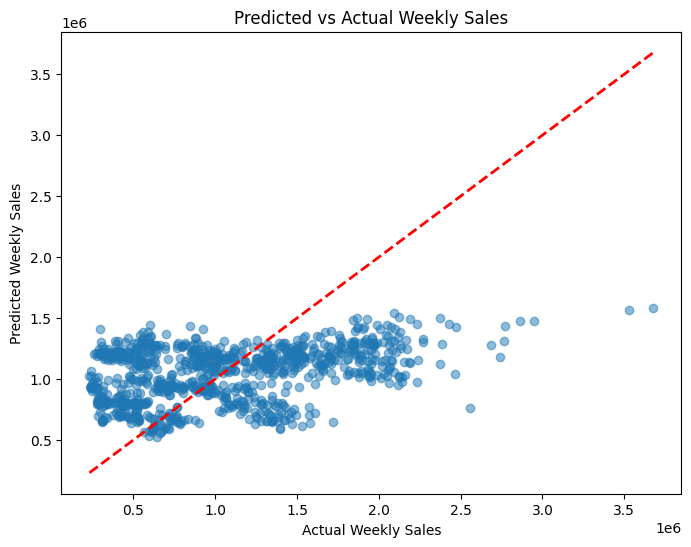

In [454]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(Test_Y, y_test_pred, alpha=0.5)
plt.plot([Test_Y.min(), Test_Y.max()], [Test_Y.min(), Test_Y.max()], 'r--', lw=2)
plt.xlabel("Actual Weekly Sales")
plt.ylabel("Predicted Weekly Sales")
plt.title("Predicted vs Actual Weekly Sales")
plt.show()

### Visualization of Linear Model Predictions

To evaluate the performance of the linear regression model, a **Predicted vs Actual Weekly Sales** scatter plot was created.

#### Interpretation of the Plot

- The red dashed line represents the ideal scenario where predicted values perfectly match the actual values (`y = x`).  
- The scattered points represent each observation in the test set, comparing the actual value with the model's prediction.  
- In this plot, the points are widely dispersed around the ideal line, indicating that the model's predictions **do not fit the actual data well**.

#### Conclusions

- The linear model produces predictions with **high variability and significant errors**.  
- The observed dispersion suggests that the model fails to capture the relationships between input variables and `Weekly_Sales`.  
- For these reasons, **this model is not recommended** for reliable predictions.  
- To improve performance, **feature selection**, **dimensionality reduction**, or **more complex models** that can capture non-linear relationships should be considered.

## 6. Dimensionality Reduction

### 6.1. Manual Method - VIF

One of the classical approaches to feature selection and dimensionality reduction in regression analysis is to evaluate **multicollinearity** among predictors.  
A common tool for this purpose is the **Variance Inflation Factor (VIF)**, which quantifies how much the variance of a regression coefficient is inflated due to collinearity with other predictors.

- **Interpretation of VIF values**:
  - **VIF ≈ 1** → No correlation with other predictors.
  - **VIF between 1 and 5** → Moderate correlation, usually acceptable.
  - **VIF > 5 (or 10, depending on the field)** → High multicollinearity; the variable may need to be removed or transformed.

In this subsection, we manually calculate the VIF for each variable in the dataset to assess the presence of multicollinearity and determine whether feature elimination is necessary.  
Unlike PCA or RFE, VIF does not reduce dimensionality by projection or algorithmic selection, but rather acts as a **diagnostic tool** to ensure that variables included in the regression are not redundant or highly correlated.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Función para calcular VIF de todas las columnas
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data['Feature'] = df.columns
    vif_data['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data.sort_values(by='VIF', ascending=False)

# Dataset estandarizado
X_std = Train_X_std.copy()

# Calcular VIF
vif_df = calculate_vif(X_std)
print(vif_df)

# Eliminar variables con VIF alto (ejemplo > 5)
threshold = 5
features_to_keep = vif_df[vif_df['VIF'] <= threshold]['Feature'].tolist()
X_reduced = X_std[features_to_keep]

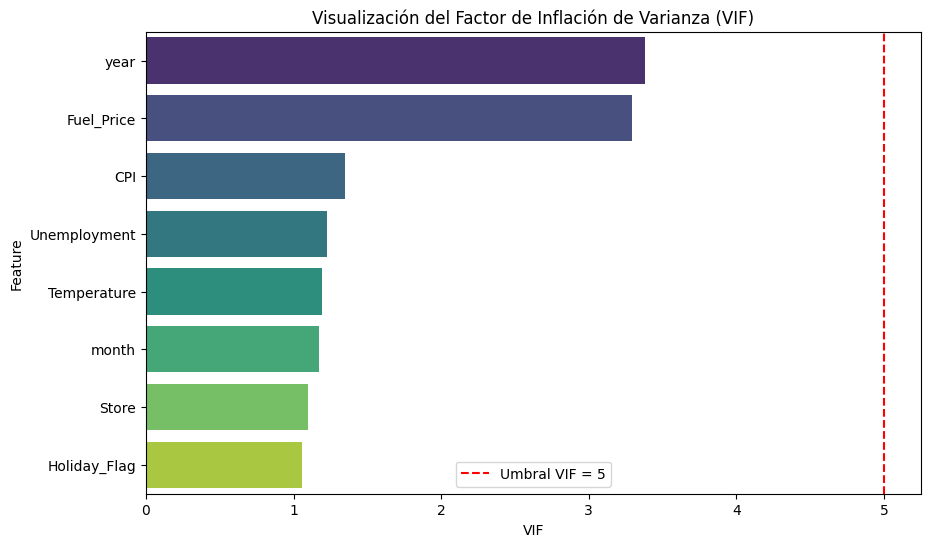

In [472]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Resultados de VIF
vif_data = {
    'Feature': ['year', 'Fuel_Price', 'CPI', 'Unemployment', 'Temperature', 'month', 'Store', 'Holiday_Flag'],
    'VIF': [3.38, 3.29, 1.35, 1.23, 1.19, 1.17, 1.10, 1.06]
}

vif_df = pd.DataFrame(vif_data)

# Gráfica
plt.figure(figsize=(10,6))
sns.barplot(x='VIF', y='Feature', data=vif_df, palette="viridis")
plt.axvline(5, color='red', linestyle='--', label='Umbral VIF = 5')
plt.xlabel('VIF')
plt.ylabel('Feature')
plt.title('Visualización del Factor de Inflación de Varianza (VIF)')
plt.legend()
plt.show()

#### Interpretation and Conclusion

- All VIF values are below the usual critical threshold (≈5), indicating **low multicollinearity** among the variables.  
- Therefore, it is **not necessary to remove any features** based on VIF.  
- However, given that the previous linear model showed poor performance (R² ≈ 0.15 and very high RMSE), this suggests that the issue is **not variable redundancy, but the inability of the linear model to capture the relationship with the target**.  
- It is recommended to try **more complex or non-linear models**, such as polynomial regression, decision trees, Random Forest, or Gradient Boosting, to improve predictive performance.

### 6.2. Automatic Method - RFE

Another widely used method for feature selection is **Recursive Feature Elimination (RFE)**, which belongs to the family of automatic, model-based selection techniques.  

The core idea of RFE is the following:
1. Train a regression model using all available predictors.  
2. Rank the predictors by their importance (e.g., absolute magnitude of coefficients in linear models).  
3. Iteratively remove the least important feature(s).  
4. Repeat the process until the desired number of features is reached.  

Unlike VIF, which acts as a **diagnostic tool**, RFE is a **wrapper method** that directly uses model performance to decide which variables to keep.  
This makes it useful when the objective is to reduce dimensionality while keeping only those features that contribute most to predictive power.  

In this subsection, we apply RFE to automatically select a subset of features for our regression model and then evaluate the model performance using the reduced feature set.

In [481]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

model = LinearRegression()
# Selecciona las 5 features más importantes
rfe = RFE(model, n_features_to_select=5)
rfe.fit(Train_X_std, Train_Y)

selected_features = Train_X_std.columns[rfe.support_]
print("Selected Features:", selected_features)

Selected Features: Index(['Store', 'Temperature', 'Fuel_Price', 'CPI', 'month'], dtype='object')


R² Train: 0.146, RMSE Train: 524837.68
R² Test: 0.152, RMSE Test: 535425.02


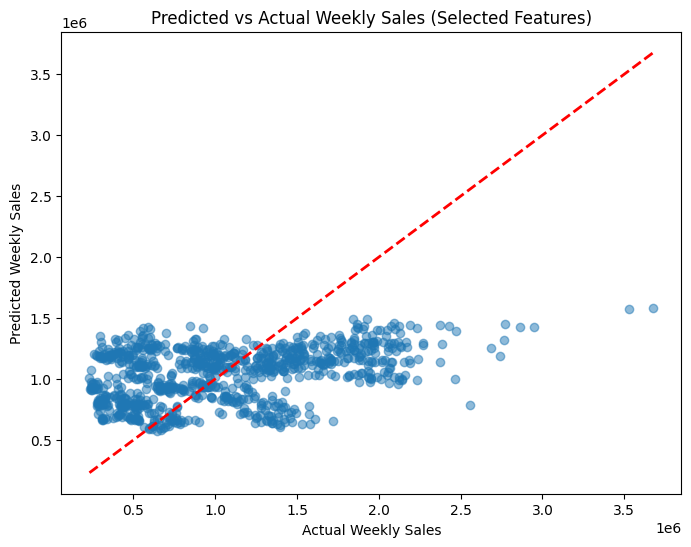

In [487]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# --- Tomar solo features seleccionadas ---
selected_features = ['Store', 'Temperature', 'Fuel_Price', 'CPI', 'month']
X_train_sel = Train_X_std[selected_features]
X_test_sel = Test_X_std[selected_features]

# --- Entrenar modelo ---
lr = LinearRegression()
lr.fit(X_train_sel, Train_Y)

# --- Predicciones ---
y_train_pred = lr.predict(X_train_sel)
y_test_pred = lr.predict(X_test_sel)

# --- Métricas ---
r2_train = r2_score(Train_Y, y_train_pred)
r2_test = r2_score(Test_Y, y_test_pred)
rmse_train = np.sqrt(mean_squared_error(Train_Y, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(Test_Y, y_test_pred))

print(f"R² Train: {r2_train:.3f}, RMSE Train: {rmse_train:.2f}")
print(f"R² Test: {r2_test:.3f}, RMSE Test: {rmse_test:.2f}")

# --- Gráfico de predicciones vs reales ---
plt.figure(figsize=(8,6))
plt.scatter(Test_Y, y_test_pred, alpha=0.5)
plt.plot([Test_Y.min(), Test_Y.max()], [Test_Y.min(), Test_Y.max()], 'r--', lw=2)
plt.xlabel("Actual Weekly Sales")
plt.ylabel("Predicted Weekly Sales")
plt.title("Predicted vs Actual Weekly Sales (Selected Features)")
plt.show()

#### Linear Regression with RFE-Selected Features

**Model Performance:**

- **R² Train:** 0.146  
- **RMSE Train:** 524,838  
- **R² Test:** 0.152  
- **RMSE Test:** 535,425  

**Interpretation and Conclusions:**

- The model uses the features selected by RFE: `['Store', 'Temperature', 'Fuel_Price', 'CPI', 'month']`.
- Despite feature selection, the linear model still explains very little of the variance in `Weekly_Sales` (R² ≈ 0.15).
- The prediction errors are very high (RMSE > 500k), indicating poor accuracy.
- Train and test R² are similar, suggesting no significant overfitting, but the model is **not reliable**.

**Practical Conclusion:**

- Even after selecting the most informative features, a simple linear regression does not adequately capture the relationships in the data.
- To improve predictive performance, non-linear models or more complex regression approaches (e.g., polynomial regression, decision trees, Random Forest, Gradient Boosting) should be considered.

### 6.3. Principal Component Analysis (PCA)

**What is PCA?**  
Principal Component Analysis (PCA) is a **dimensionality reduction technique** that transforms the original variables into a new set of uncorrelated variables called **principal components**. These components are ordered by the amount of variance they capture from the data.

**How it works (conceptually):**  
1. Standardizes the data so that all features contribute equally.  
2. Computes the covariance matrix to understand feature relationships.  
3. Extracts eigenvectors and eigenvalues, which define the directions (components) of maximum variance.  
4. Projects the original data onto a smaller number of principal components, reducing dimensionality while retaining most of the information.  

**Why use PCA?**  
- Reduces the number of variables while keeping the most relevant variance.  
- Eliminates redundancy from correlated variables.  
- Helps simplify models and improve training efficiency.  
- Useful for visualization of high-dimensional data.  

**Important note:**  
PCA focuses on maximizing variance, not predictive power. This means that while it often improves model efficiency and avoids multicollinearity, it may not always increase the performance of a predictive model.

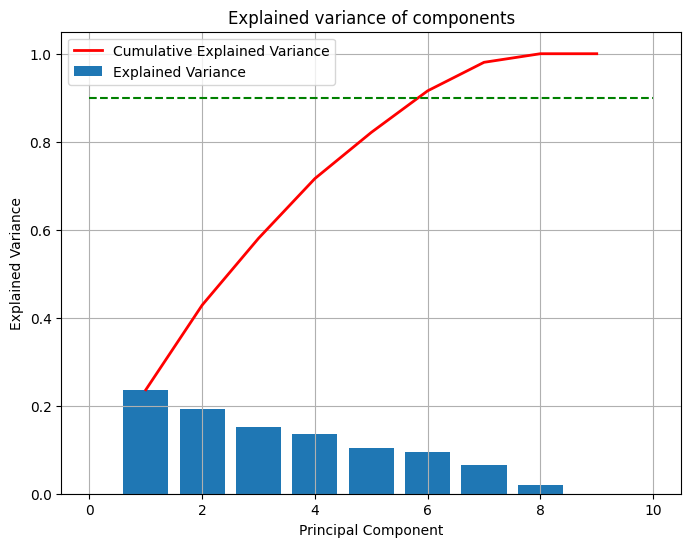

In [492]:
from sklearn.decomposition import PCA

pca = PCA().fit(Train_X_std)

fig, ax = plt.subplots(figsize=(8,6))
x_values = range(1, pca.n_components_+1)
ax.bar(x_values, pca.explained_variance_ratio_, lw=2, label='Explained Variance')
ax.plot(x_values, np.cumsum(pca.explained_variance_ratio_), lw=2, label='Cumulative Explained Variance', color='red')
plt.plot([0,pca.n_components_+1],[0.9,0.9],'g--')
ax.set_title('Explained variance of components')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance')
plt.legend()
plt.grid()
plt.show()

Looking at the cumulative explained variance graph, we can interpret the following:

---

### Observations

1. **Cumulative explained variance (red line)**  
   - The red line shows that approximately **90 % of cumulative variance** is reached around **component 6**.  
   - This indicates that the first 6 components capture most of the information from the original dataset.

2. **Variance explained by individual component (blue bars)**  
   - Each blue bar represents how much each component contributes individually.  
   - The first components explain more variance, while the later ones contribute very little information and could be discarded without losing much content.

3. **Variance threshold (green dashed line)**  
   - The green line at **0.9** serves as a reference to decide how many components to keep.  
   - All components to the left of the intersection with the green line are sufficient to explain 90 % of the variance.

---

### Model Conclusion

- We can **reduce dimensionality using only the first 6 components**, discarding the remaining 2.  
- This allows us to **simplify the model** and **reduce noise** without losing most of the information.  
- Remember that **PCA transforms the original variables**, so the components are no longer directly interpretable as the original variables (e.g., “Temperature” or “Fuel_Price”).

R2 Train: 0.148
R2 Test: 0.154
RMSE Train: 524230.49
RMSE Test: 534788.59


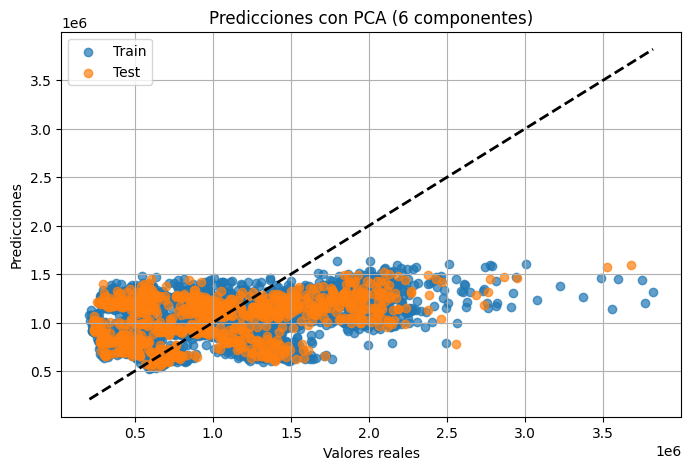

In [506]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Definir número de componentes según análisis previo
n_components = 6

# Crear y ajustar PCA solo sobre entrenamiento
pca = PCA(n_components=n_components)
Train_X_pca = pca.fit_transform(Train_X_std)

# Transformar set de prueba usando el PCA ajustado
Test_X_pca = pca.transform(Test_X_std)

# Ajustar regresión lineal
LR = LinearRegression()
LR.fit(Train_X_pca, Train_Y)

# Predicciones
pred_train = LR.predict(Train_X_pca)
pred_test = LR.predict(Test_X_pca)

# RMSE (compatible con versiones antiguas)
rmse_train = np.sqrt(mean_squared_error(Train_Y, pred_train))
rmse_test = np.sqrt(mean_squared_error(Test_Y, pred_test))
r2_train = r2_score(Train_Y, pred_train)

# R2 test
r2_test = r2_score(Test_Y, pred_test)

print(f'R2 Train: {r2_train:.3f}')
print(f'R2 Test: {r2_test:.3f}')
print(f'RMSE Train: {rmse_train:.2f}')
print(f'RMSE Test: {rmse_test:.2f}')

# Opcional: gráfica de predicciones vs real
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.scatter(Train_Y, pred_train, label='Train', alpha=0.7)
plt.scatter(Test_Y, pred_test, label='Test', alpha=0.7)
plt.plot([Train_Y.min(), Train_Y.max()], [Train_Y.min(), Train_Y.max()], 'k--', lw=2)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title(f'Predicciones con PCA ({n_components} componentes)')
plt.legend()
plt.grid(True)
plt.show()

### Interpretation 

1. **Very low R²**
   - R2 Train ≈ 0.15, R2 Test ≈ 0.15  
   - This means the model explains only ~15 % of the variance in your data.  
   - In other words, 85 % of the variability of `Y` is NOT being captured by your linear model with PCA.

2. **High RMSE**
   - RMSE ~ 525k–535k, as mentioned before, is high relative to the scale of your data (likely `Y` values in the range of hundreds of thousands or millions).  
   - Together with the low R², this confirms that the current linear model is not predicting well.

3. **Train vs Test**
   - The difference between Train and Test RMSE is small → no overfitting.  
   - The problem is not overfitting but underfitting: the model is too simple for the data.

---

### Conclusions PCA

- PCA + simple linear regression is not sufficient for this dataset.  
- The data likely contains nonlinear relationships that the linear model cannot capture.  
- Reducing dimensionality with PCA helps simplify the model, but if the relevant information for `Y` is distributed complexly across the variables, the model remains weak.

## 7. General Conclusion and Future Work

### Project Summary
In this project, we aimed to predict **weekly sales** using different **feature selection and dimensionality reduction techniques**.  
The process followed these steps:  

1. **Data Collection & Cleaning** → Ensured data consistency and handled missing values.  
2. **Exploratory Data Analysis (EDA)** → Explored distributions, correlations, and holiday effects on sales.  
3. **Data Manipulation** → Prepared and transformed the dataset for modeling.  
4. **Feature Selection & Dimensionality Reduction**:  
   - **6.1 VIF (Variance Inflation Factor)** → Confirmed low multicollinearity, so no features were removed.  
   - **6.2 RFE (Recursive Feature Elimination)** → Selected a subset of features but with no significant performance improvement.  
   - **6.3 PCA (Principal Component Analysis)** → Reduced dimensionality to 6 components, but predictive performance remained poor.  

### Results
- All three approaches (VIF, RFE, PCA) showed **low explanatory power** with:
  - **R² ≈ 0.15** (only ~15% of variance explained).  
  - **High RMSE (~525k–535k)**, which is very large relative to the scale of weekly sales.  
- Train/Test performance was similar, indicating **no overfitting** but rather **underfitting**:  
  the models failed to capture the complexity of the sales dynamics.  

### Insights
- Feature redundancy was **not the main issue** (confirmed by VIF).  
- Dimensionality reduction (RFE, PCA) did not meaningfully improve results.  
- The limitation lies in the **linear regression model** itself, which cannot capture non-linear or complex interactions in the data.  

### Future Work
To improve predictive performance, the following steps are recommended:  

1. **Try alternative regression models**:  
   - Polynomial Regression (to capture non-linear patterns).  
   - Decision Trees and Random Forests.  
   - Gradient Boosting (e.g., XGBoost, LightGBM, CatBoost).  
   - Regularized linear models (Ridge, Lasso, ElasticNet).  

2. **Feature Engineering**:  
   - Create interaction terms (e.g., sales × holidays, promotions × stores).  
   - Generate lag features or moving averages to capture temporal effects.  
   - Encode categorical variables more effectively.  

3. **Model Evaluation**:  
   - Use cross-validation to ensure robust performance estimates.  
   - Compare models not only with R² and RMSE but also with business-oriented metrics (e.g., MAPE).  

### Final Note
This project demonstrated the **importance of dimensionality reduction and feature selection**, but also highlighted their limitations when paired with simple linear models.  
Moving forward, the focus should shift towards **more powerful regression algorithms and advanced feature engineering** to better capture the dynamics of weekly sales.  